# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [88]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [89]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [91]:
def P1(num_examples=5):
    ### STUDENT START ###
    try:
        num_examples = int(num_examples)
        if(num_examples == 0):
            print "Please enter number of samples to be greater than 0"
            raise 
        for i in range(num_examples):
            print("\n---------------------------------------------------------------")
            print("Class name: " + newsgroups_train.target_names[train_labels[i]])
            print("Text content:")
            print(train_data[i])
    except Exception as e:
        print "Exception Occured: ", e.args
        raise
    ### STUDENT END ###
P1(5)



---------------------------------------------------------------
Class name: comp.graphics
Text content:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

---------------------------------------------------------------
Class name: talk.religion.misc
Text content:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [4]:
def P2():
    ### STUDENT START ###
    try:
        ##### 2.a
        vectorizer = CountVectorizer(min_df=1)
        X = vectorizer.fit_transform(train_data)
        print 'Answer to 2.a :'
        print 'Size of vocabulary: ', X.shape[1]
        print 'Average number of non-zero features per example: ', round(1.0 * X.nnz/X.shape[0],3)
        print 'Fraction of entries in the matrix that are non zero: ', round(1.0 * X.nnz/ (X.shape[1] * X.shape[0]),3)
        
        ###### 2.b
        feature_names = vectorizer.get_feature_names()
        #print 'Feature set:',feature_names
        #feature_names.sort()
        print '\nAnswer to 2.b :'
        print '0th feture: %s  and last feature: %s' %(feature_names[0], feature_names[len(feature_names)-1])
        
        ###### 2.c
        # setting up the custome vocabulary
        cust_vocab = ['atheism', 'religion', 'graphics', 'space']
        # initialise the Count vectorizer with the custom vocabulary
        cust_vectorizer = CountVectorizer(min_df=1,vocabulary = cust_vocab )
        X = cust_vectorizer.fit_transform(train_data)
        print '\nAnswer to 2.c:'
        print 'Size of vocabulary with custom vocabulary:',X.shape[1]
        print 'Average number of non-zero feaures per example: ', round(1.0 * X.nnz/X.shape[0],3)
        
        ###### 2.d
        bigram_vectorizer = CountVectorizer(analyzer='char',ngram_range=(2,3), min_df=1)
        bi_X = bigram_vectorizer.fit_transform(train_data)
        print '\nAnswer to 2.d :'
        print 'Size of vocabulary for bigram & trigram: ', bi_X.shape[1]
        #print bigram_vectorizer.vocabulary_
        
        
        
        ###### 2.e
        min_vectorizer = CountVectorizer(min_df=10)
        X = min_vectorizer.fit_transform(train_data)
        print '\nAnswer to 2.e :'
        print 'Size of vocabulary with Min-df = 10 : ', X.shape[1]
        
        ###### 2.f
        train_vectorizer,dev_vectorizer1 = CountVectorizer(encoding='utf8'),CountVectorizer(encoding='utf8')
        X_train = train_vectorizer.fit(train_data)
        X_dev = dev_vectorizer1.fit(dev_data)
        print '\nAnswer to 2.f : '
        # Determine how many features are common between training and dev set
        common =  len(list(set(X_train.get_feature_names()) & set(X_dev.get_feature_names())))
        print 'Number of features common between training and dev set: ', common
        print "Fraction missing ", round(1.0*(len(X_dev.get_feature_names())-common)/len(X_dev.get_feature_names()),3)

        
    except Exception as e:
        print "Exception Occured: ", e.args
        raise

### STUDENT END ###
P2()

Answer to 2.a :
Size of vocabulary:  26879
Average number of non-zero features per example:  96.706
Fraction of entries in the matrix that are non zero:  0.004

Answer to 2.b :
0th feture: 00  and last feature: zyxel

Answer to 2.c:
Size of vocabulary with custom vocabulary: 4
Average number of non-zero feaures per example:  0.268

Answer to 2.d :
Size of vocabulary for bigram & trigram:  35478

Answer to 2.e :
Size of vocabulary with Min-df = 10 :  3064

Answer to 2.f : 
Number of features common between training and dev set:  12219
Fraction missing  0.248


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [138]:
def P3():
    ### STUDENT START ###
    try:
        #default CountVectorizer
        def_vectorizer = CountVectorizer()
        x_train = def_vectorizer.fit_transform(train_data)
        x_dev   = def_vectorizer.transform(dev_data)
        x_test =  def_vectorizer.transform(test_data)
        k_values = {'n_neighbors':[1,3,5,7,9]}
        knn = KNeighborsClassifier()
        
        
        pipelineKnn = Pipeline([
                ('kNN', KNeighborsClassifier())
            ])
        
        pipelineMNB = Pipeline([
                ('multiNB' , MultinomialNB())
            ])
        
        pipelineLog = Pipeline([
                ( 'logisR', LogisticRegression(penalty='l2'))
            ])

        parametersKnn = {
        'kNN__n_neighbors': (5,10,20,30,40,50,60,70,80,90,100,150,200,250,300)
            }
        
        parametersMulti = {
            'multiNB__alpha':(1,0.1,0.01,0.001,0.0001,0)
        }
        
        parametersLog ={
            'logisR__C': (0.001,0.01,0.1,1,10,100)
        }
            
        
        param = [parametersKnn,parametersMulti,parametersLog]
        pipe = [pipelineKnn,pipelineMNB,pipelineLog]

        print("\nPerforming grid search...")
        for i in range(len(param)):
            # initialize grid search
            grid_search = GridSearchCV(pipe[i], param[i], n_jobs=-1)
            grid_search.fit(x_train,train_labels)
            print("\n")
            print("pipeline:", [name for name, _ in pipe[i].steps])
            print("parameters:" ,param[i])
            print("\nBest score: {:0.3f}".format(grid_search.best_score_))
            print("Best parameters set:")
            best_parameters = grid_search.best_estimator_.get_params()
            for param_name in sorted(param[i].keys()):
                print("\t{}: {}".format(param_name, best_parameters[param_name]))
            y_true, y_pred = dev_labels, grid_search.predict(x_dev)
            print"f1 score on dev data: ",(metrics.f1_score(y_true, y_pred))
            print("Grid scores on Training  data:")
            for params, mean_score, scores in grid_search.grid_scores_:
                print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))
        C = parametersLog["logisR__C"]
        for j in range(len(C)):
            clf_l2_lr = LogisticRegression(C =C[j],penalty='l2')
            clf_l2_lr.fit(x_train,train_labels)
            coef = clf_l2_lr.coef_
            sq_coef = np.power(coef,2)
            sum_coef = sq_coef.sum(axis=1)
            print 'For C = %0.3f' %(C[j])
            for k in range(coef.shape[0]):
                print 'Class: %s Sum of Squared weight Value: % 0.2f' %(k+1,sum_coef[k])
               
    except Exception as e:
        print "Exception Occured: ", e.args
        

    ### STUDENT END ###
P3()


Performing grid search...


('pipeline:', ['kNN'])
('parameters:', {'kNN__n_neighbors': (5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300)})

Best score: 0.446
Best parameters set:
	kNN__n_neighbors: 150
f1 score on dev data:  0.422000000025
Grid scores on Training  data:
0.409 (+/-0.051) for {'kNN__n_neighbors': 5}
0.413 (+/-0.039) for {'kNN__n_neighbors': 10}
0.419 (+/-0.015) for {'kNN__n_neighbors': 20}
0.405 (+/-0.012) for {'kNN__n_neighbors': 30}
0.412 (+/-0.024) for {'kNN__n_neighbors': 40}
0.432 (+/-0.012) for {'kNN__n_neighbors': 50}
0.438 (+/-0.010) for {'kNN__n_neighbors': 60}
0.428 (+/-0.021) for {'kNN__n_neighbors': 70}
0.431 (+/-0.012) for {'kNN__n_neighbors': 80}
0.440 (+/-0.019) for {'kNN__n_neighbors': 90}
0.435 (+/-0.021) for {'kNN__n_neighbors': 100}
0.446 (+/-0.021) for {'kNN__n_neighbors': 150}
0.441 (+/-0.034) for {'kNN__n_neighbors': 200}
0.420 (+/-0.023) for {'kNN__n_neighbors': 250}
0.405 (+/-0.011) for {'kNN__n_neighbors': 300}


('pipeline:', ['

/Users/hetal/anaconda/lib/python2.7/site-packages/sklearn/naive_bayes.py:435: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)
/Users/hetal/anaconda/lib/python2.7/site-packages/sklearn/naive_bayes.py:435: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)
/Users/hetal/anaconda/lib/python2.7/site-packages/sklearn/naive_bayes.py:435: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)




('pipeline:', ['logisR'])
('parameters:', {'logisR__C': (0.001, 0.01, 0.1, 1, 10, 100)})

Best score: 0.766
Best parameters set:
	logisR__C: 0.1
f1 score on dev data:  0.696624354242
Grid scores on Training  data:
0.660 (+/-0.019) for {'logisR__C': 0.001}
0.734 (+/-0.015) for {'logisR__C': 0.01}
0.766 (+/-0.006) for {'logisR__C': 0.1}
0.763 (+/-0.006) for {'logisR__C': 1}
0.752 (+/-0.002) for {'logisR__C': 10}
0.748 (+/-0.007) for {'logisR__C': 100}
For C = 0.001
Class: 1 Sum of Squared weight Value:  0.17
Class: 2 Sum of Squared weight Value:  0.20
Class: 3 Sum of Squared weight Value:  0.18
Class: 4 Sum of Squared weight Value:  0.19
For C = 0.010
Class: 1 Sum of Squared weight Value:  2.54
Class: 2 Sum of Squared weight Value:  2.94
Class: 3 Sum of Squared weight Value:  2.86
Class: 4 Sum of Squared weight Value:  2.25
For C = 0.100
Class: 1 Sum of Squared weight Value:  27.12
Class: 2 Sum of Squared weight Value:  24.66
Class: 3 Sum of Squared weight Value:  27.46
Class: 4 Sum of

ANSWER: 
a. Why doesn't nearest neighbors work well for this problem?
In this case words that overlap between different categories is high i.e. if the word belongs to more than one class  with similar weight knn will suffer badly as it will not be able to properly predict. 

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?
In this particular problem, our training size of data is less than the features against which we are trying to train our model on ( vocabulary size). 
Due to this, Logistic regression overfits on training data and does not generalize well while Naive Bayes works  well as the estimates are based on the joint probability distribution and also using the prior probabilities help imprive the prediction.

c. Logistic regression estimates a weight vector for each class, which you can access with the coef_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C. (c = 1 / lambda) 
As the value of C increases the sum of square weight value also increases. This means that at lower value of C ( larger lambda) the model is penalised more v/s at larger values of C ( smaller Lambda) the model isnt penalised well and fails to generalise. 

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

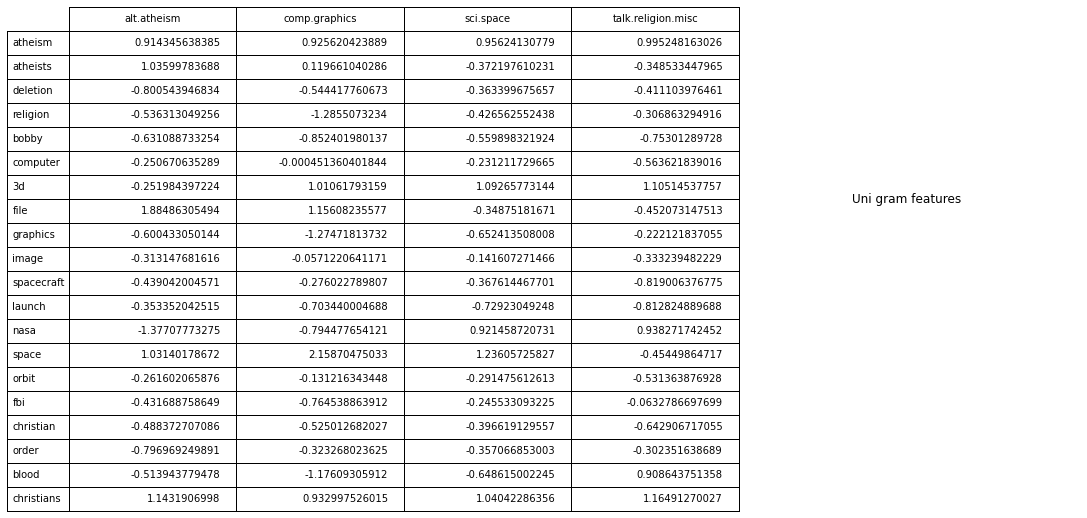

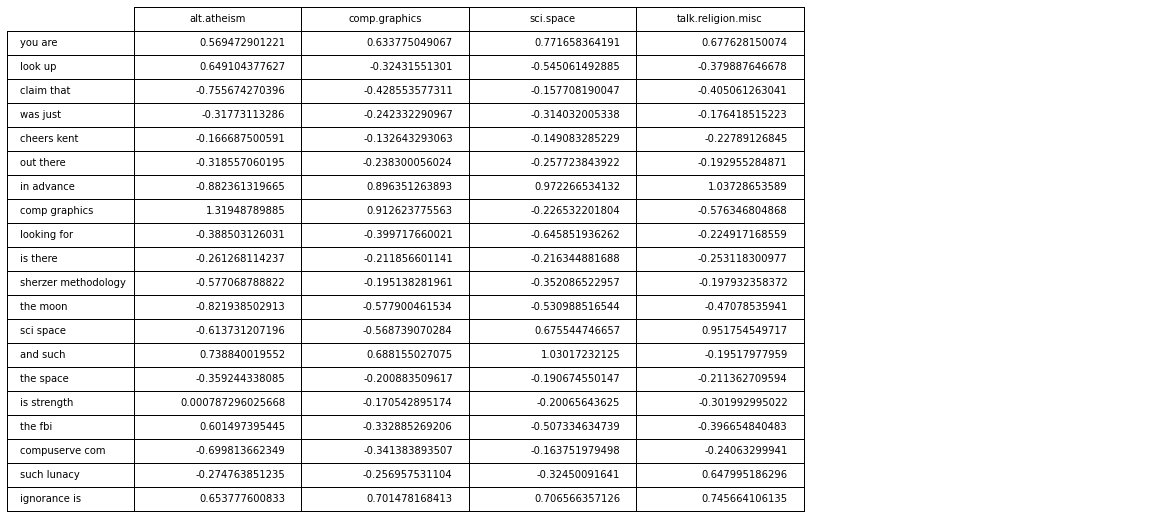

In [102]:
def P4():
    ### STUDENT START ###
    try:
        #default CountVectorizer
        def_vectorizer = CountVectorizer(min_df=1)
        x_train = def_vectorizer.fit_transform(train_data)
        clf_log = LogisticRegression(tol=.01)
        clf_log.fit(x_train,train_labels)
        coef = clf_log.coef_
    
        indexes = np.argpartition(coef, -5)[:,-5:].flatten()
        feature_value  = np.take(coef, indexes, axis=1)
        names = np.array([def_vectorizer.get_feature_names()[index].encode('utf-8') for index in indexes])
        fig=plt.figure()
        ax = fig.add_subplot(211)
        feature_value =  feature_value.reshape(feature_value.shape[1],feature_value.shape[0])
        the_table = ax.table(cellText=feature_value,
                             rowLabels = names,
                             colLabels = np.unique(newsgroups_train.target_names),
                             loc='left')
        the_table.scale(2,2)
        ax.axis('off')
        plt.show()
        
        bi_vectorizer = CountVectorizer(ngram_range=(2,2))
        x_train = bi_vectorizer.fit_transform(train_data)
        clf_log = LogisticRegression()
        clf_log.fit(x_train,train_labels)
        coef = clf_log.coef_
        indexes = np.argpartition(coef, -5)[:,-5:].flatten()
        feature_value  = np.take(coef, indexes, axis=1)
        names = np.array([bi_vectorizer.get_feature_names()[index].encode('utf-8') for index in indexes])
        fig=plt.figure()
        ax = fig.add_subplot(212)
        feature_value =  feature_value.reshape(feature_value.shape[1],feature_value.shape[0])
        the_table = ax.table(cellText=feature_value,
                             rowLabels = names,
                             colLabels = np.unique(newsgroups_train.target_names),
                             loc='left')
        the_table.scale(2,2)
        ax.axis('off')
        plt.show()
        
    except Exception as e:
        print "Exception Occured: ", e.args
        raise
    ### STUDENT END ###
P4()

ANSWER: Compared to the unigram table the bigram table has bigrams that are very common expressions such as 'and such', 'is there','looking for','was just','you are','look up' which are more common and we wouldn't have associated these bigrams as a indicative of particular class of text.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [127]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    ### STUDENT START ###
    # converting everything to lower case
    s = s.lower()
    
    # removing stop words using the words from http://www.ranks.nl/stopwords 
    stop_words = ('a','about','above','after','again','against','all','am','an','and','any','are','aren\'t','as',
                   'at','be','because','been','before','being','below','between','both','but','by','can\'t','cannot',
                   'could','couldn\'t','did','didn\'t','do','does','doesn\'t','doing','don\'t','down','during',
                   'each','few','for','from','further','had','hadn\'t','has','hasn\'t','have','haven\'t','having',
                   'he','he\'d','he\'ll','he\'s','her','here','here\'s','hers','herself','him','himself','his','how',
                   'how\'s','i','i\'d','i\'ll','i\'m','i\'ve','if','in','into','is','isn\'t','it','it\'s','its',
                   'itself','let\'s','me','more','most','mustn\'t','my','myself','no','nor','not','of','off','on',
                   'once','only','or','other','ought','our','ours','ourselves','out','over','own','same','shan\'t',
                   'she','she\'d','she\'ll','she\'s','should','shouldn\'t','so','some','such','than','that','that\'s',
                   'the','their','theirs','them','themselves','then','there','there\'s','these','they','they\'d',
                   'they\'ll','they\'re','they\'ve','this','those','through','to','too','under','until','up',
                   'very','was','wasn\'t','we','we\'d','we\'ll','we\'re','we\'ve','were','weren\'t','what',
                   'what\'s','when','when\'s','where','where\'s','which','while','who','who\'s','whom','why',
                   'why\'s','with','won\'t','would','wouldn\'t','you','you\'d','you\'ll','you\'re','you\'ve',
                   'your','yours','yourself','yourselves')
    pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
    s = pattern.sub('', s)

    #replace all non alpha numeric characters with a space 
    for f in re.findall("(\W+)", s):
        s = s.replace(f, ' ')

    # removing all sequences of number and replacing it with NUM
    pattern = re.compile(r'\b\d+\b\s*')
    s = pattern.sub('NUM ', s)
 
     #Stemming 
    for f in (re.findall(r'\b(\w+)(ing|ly|ed|ious|ies|ive|es|s|ment)\b\s*', s)):
        stem = f[0]
        s = s.replace(f[0]+f[1], stem)

    
    return s
    ### STUDENT END ###
    
    
def P5():
    ### STUDENT START ###
    try:
        def_vectorizer = CountVectorizer(preprocessor=empty_preprocessor,min_df=1)
        x_train = def_vectorizer.fit_transform(train_data)
        x_dev   = def_vectorizer.transform(dev_data)
        clf_log = LogisticRegression(C=0.1,penalty='l2')
        clf_log.fit(x_train,train_labels)
        y_true, y_pred = dev_labels, clf_log.predict(x_dev)
        print"F1 score on dev data without preprocessing: ",(metrics.f1_score(y_true, y_pred))
        print "Size of dictionary without preprocessing",x_train.shape[1]
        
        def_vectorizer = CountVectorizer(preprocessor=better_preprocessor,min_df=1)
        x_train = def_vectorizer.fit_transform(train_data)
        x_dev   = def_vectorizer.transform(dev_data)
        clf_log = LogisticRegression(C=0.1,penalty='l2')
        clf_log.fit(x_train,train_labels)
        y_true, y_pred = dev_labels, clf_log.predict(x_dev)
        print"F1 score on dev data After preprocessing: ",(metrics.f1_score(y_true, y_pred))
        print "Size of dictionary after preprocessng:",x_train.shape[1]
    except Exception as e:
        print "Exception Occured: ", e.args
        raise
    ### STUDENT END ###
P5()

F1 score on dev data without preprocessing:  0.701397454667
Size of dictionary without preprocessing 33291
F1 score on dev data After preprocessing:  0.731008407741
Size of dictionary after preprocessng: 21086


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

Number of learned weights that are Non Zero for C: 0.001  = 5
Vocab Size : 2, f1 Score on dev data: 0.323
Number of learned weights that are Non Zero for C: 0.01  = 36
Vocab Size : 18, f1 Score on dev data: 0.467
Number of learned weights that are Non Zero for C: 0.1  = 364
Vocab Size : 209, f1 Score on dev data: 0.696


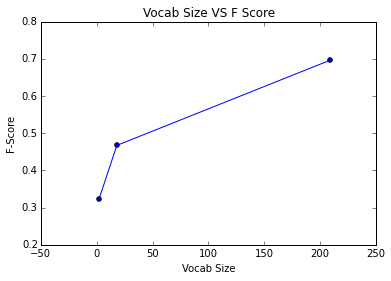

In [135]:
def P6():
    ### STUDENT START ###
    try:
        #Keep this random seed here to make comparison easier.
        np.random.seed(0)
        # running logistic regression with different values of C
        #C = [0.001,0.01,0.1,0.25,0.5,0.75,1.0,10,50,100]
        C = [0.001,0.01,0.1]
        # arrays to hold the f1 score and vocabulary size
        f1_score = np.zeros(len(C))
        vocab_size = np.zeros(len(C),dtype=int)
        for i, c in enumerate(C):
            # logistic regression using l1 penalty 
            def_vectorizer = CountVectorizer()
            x_train = def_vectorizer.fit_transform(train_data)
            x_dev   = def_vectorizer.transform(dev_data)
            clf_log_l1 = LogisticRegression(C=c,penalty='l1',tol=0.01)
            clf_log_l1.fit(x_train,train_labels)
            coef = clf_log_l1.coef_
            # The number of weights that are non zero
            print "Number of learned weights that are Non Zero for C: %s  = %s" %(c, len(coef.nonzero()[1]))
            vocab = np.array([def_vectorizer.get_feature_names()[index].encode('utf-8') for index in np.unique(coef.nonzero()[1])])
            vocab_vect = CountVectorizer(vocabulary = vocab)
            x_train_vocab = vocab_vect.fit_transform(train_data)
            x_dev_vocab   = vocab_vect.transform(dev_data)
            # logistic regression using l2 penalty 
            clf_log_l2 = LogisticRegression(penalty='l2')
            clf_log_l2.fit(x_train_vocab,train_labels)
            y_true, y_pred = dev_labels, clf_log_l2.predict(x_dev_vocab)
            vocab_size[i] = vocab.shape[0]
            f1_score[i] = metrics.f1_score(y_true, y_pred)
            #print"f1 score on trimmed dev data: ",f1_score[i]
            print 'Vocab Size : %s, f1 Score on dev data: %0.03f'%(vocab_size[i],f1_score[i])
        plt.title("Vocab Size VS F Score")
        plt.plot(vocab_size, f1_score)
        plt.xlabel('Vocab Size')
        plt.ylabel('F-Score')
        plt.scatter(vocab_size, f1_score)
        plt.show()
    except Exception as e:
        print "Exception Occured: ", e.args
        raise
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [84]:
def P7():
    ### STUDENT START ###
    try:
        #using pipeline for vectorizer and classifer
        #vectorizer = TfidfVectorizer(min_df=1)
        tfid_lr = Pipeline([
                ('tf_id_vect',TfidfVectorizer(min_df=1)),
                ( 'logisR', LogisticRegression(C=100))
            ])
        # fit the classifier on training data
        tfid_lr.fit(train_data,train_labels)
        #calculate the predicted probabilities on dev data
        pred_prob = tfid_lr.predict_proba(dev_data)
        # find the maximum probability for each 
        max_pred_prob = np.amax(pred_prob, axis=1)
        #find the probability of the correct label
        index = np.arange(len(dev_labels))
        correct_pred_prob = pred_prob[index,dev_labels]
        #calculate the r ratio
        r_ratio = max_pred_prob / correct_pred_prob
        # find the top 3 r ratio indexes
        indexes = np.argpartition(r_ratio, -3)[-3:]
        #find the R ratio values based on the indexes found above
        r_value  = np.take(r_ratio, indexes)
        text_dev = np.take(dev_data,indexes)
        
        
    except Exception as e:
        print "Exception Occured: ", e.args
        raise
    ## STUDENT END ###
P7()

(3,)


ANSWER: TFIDF - 

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

[2 1 1 1 1]


In [121]:
# extra space
a_vectorizer = CountVectorizer(min_df=1,token_pattern='(?u)\\b\\w+\\b',encoding='utf8')
#a_vectorizer = CountVectorizer(min_df=1,analyzer='word',ngram_range=(1,3))
#corpus = ['This is the first document.',
#           'This is the second second document.',
#           'And the third one.',
#           'I Is this the first document?',
#          ]
corpus = train_data[6][:100]
print corpus
corpus = corpus.split('\n')
print corpus
X = a_vectorizer.fit_transform(corpus)
print X.shape
print a_vectorizer.get_feature_names()

Mark Prado
  
  
Old pioneer song from the 1850's or so goes as follows:
  
  "In a cavern, in a can
[u'Mark Prado', u'  ', u'  ', u"Old pioneer song from the 1850's or so goes as follows:", u'  ', u'  "In a cavern, in a can']
(6, 18)
[u'1850', u'a', u'as', u'can', u'cavern', u'follows', u'from', u'goes', u'in', u'mark', u'old', u'or', u'pioneer', u'prado', u's', u'so', u'song', u'the']
